In [ ]:
import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS


tdiff = np.diff

class Holder(object):
    pass

def rows(x):
    return x.shape[0]

def trimr(x, front, end):
    if end > 0:
        return x[front:-end]
    else:
        return x[front:]

import statsmodels.tsa.tsatools as tsat
mlag = tsat.lagmat

def mlag_(x, maxlag):
    '''return all lags up to maxlag
    '''
    return x[:-lag]

def lag(x, lag):
    return x[:-lag]

def detrend(y, order):
    if order == -1:
        return y
    return OLS(y, np.vander(np.linspace(-1, 1, len(y)), order + 1)).fit().resid

def resid(y, x):
    r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
    return r




def coint_johansen(x, p, k, print_on_console=True):

    #    % error checking on inputs
    #    if (nargin ~= 3)
    #     error('Wrong # of inputs to johansen')
    #    end
    nobs, m = x.shape

    # why this?  f is detrend transformed series, p is detrend data
    if (p > -1):
        f = 0
    else:
        f = p

    x = detrend(x, p)
    dx = tdiff(x, 1, axis=0)
    # dx    = trimr(dx,1,0)
    z = mlag(dx, k)  # [k-1:]
#    print z.shape
    z = trimr(z, k, 0)
    z = detrend(z, f)
#    print dx.shape
    dx = trimr(dx, k, 0)

    dx = detrend(dx, f)
    # r0t   = dx - z*(z\dx)
    r0t = resid(dx, z)  # diff on lagged diffs
    # lx = trimr(lag(x,k),k,0)
    lx = lag(x, k)
    lx = trimr(lx, 1, 0)
    dx = detrend(lx, f)
#    print 'rkt', dx.shape, z.shape
    # rkt   = dx - z*(z\dx)
    rkt = resid(dx, z)  # level on lagged diffs
    skk = np.dot(rkt.T, rkt) / rows(rkt)
    sk0 = np.dot(rkt.T, r0t) / rows(rkt)
    s00 = np.dot(r0t.T, r0t) / rows(r0t)
    sig = np.dot(sk0, np.dot(inv(s00), (sk0.T)))
    tmp = inv(skk)
    # du, au = eig(np.dot(tmp, sig))
    au, du = eig(np.dot(tmp, sig))  # au is eval, du is evec
    # orig = np.dot(tmp, sig)

    # % Normalize the eigen vectors such that (du'skk*du) = I
    temp = inv(chol(np.dot(du.T, np.dot(skk, du))))
    dt = np.dot(du, temp)


    # JP: the next part can be done much  easier

    # %      NOTE: At this point, the eigenvectors are aligned by column. To
    # %            physically move the column elements using the MATLAB sort,
    # %            take the transpose to put the eigenvectors across the row

    # dt = transpose(dt)

    # % sort eigenvalues and vectors

    # au, auind = np.sort(diag(au))
    auind = np.argsort(au)
    # a = flipud(au)
    aind = flipud(auind)
    a = au[aind]
    # d = dt[aind,:]
    d = dt[:, aind]

    # %NOTE: The eigenvectors have been sorted by row based on auind and moved to array "d".
    # %      Put the eigenvectors back in column format after the sort by taking the
    # %      transpose of "d". Since the eigenvectors have been physically moved, there is
    # %      no need for aind at all. To preserve existing programming, aind is reset back to
    # %      1, 2, 3, ....

    # d  =  transpose(d)
    # test = np.dot(transpose(d), np.dot(skk, d))

    # %EXPLANATION:  The MATLAB sort function sorts from low to high. The flip realigns
    # %auind to go from the largest to the smallest eigenvalue (now aind). The original procedure
    # %physically moved the rows of dt (to d) based on the alignment in aind and then used
    # %aind as a column index to address the eigenvectors from high to low. This is a double
    # %sort. If you wanted to extract the eigenvector corresponding to the largest eigenvalue by,
    # %using aind as a reference, you would get the correct eigenvector, but with sorted
    # %coefficients and, therefore, any follow-on calculation would seem to be in error.
    # %If alternative programming methods are used to evaluate the eigenvalues, e.g. Frame method
    # %followed by a root extraction on the characteristic equation, then the roots can be
    # %quickly sorted. One by one, the corresponding eigenvectors can be generated. The resultant
    # %array can be operated on using the Cholesky transformation, which enables a unit
    # %diagonalization of skk. But nowhere along the way are the coefficients within the
    # %eigenvector array ever changed. The final value of the "beta" array using either method
    # %should be the same.


    # % Compute the trace and max eigenvalue statistics */
    lr1 = zeros(m)
    lr2 = zeros(m)
    cvm = zeros((m, 3))
    cvt = zeros((m, 3))
    iota = ones(m)
    t, junk = rkt.shape
    for i in range(0, m):
        tmp = trimr(log(iota - a), i , 0)
        lr1[i] = -t * np.sum(tmp, 0)  # columnsum ?
        # tmp = np.log(1-a)
        # lr1[i] = -t * np.sum(tmp[i:])
        lr2[i] = -t * log(1 - a[i])
        cvm[i, :] = c_sja(m - i, p)
        cvt[i, :] = c_sjt(m - i, p)
        aind[i] = i
    # end

    result = Holder()
    # % set up results structure
    # estimation results, residuals
    result.rkt = rkt
    result.r0t = r0t
    result.eig = a
    result.evec = d  # transposed compared to matlab ?
    result.lr1 = lr1
    result.lr2 = lr2
    result.cvt = cvt
    result.cvm = cvm
    result.ind = aind
    result.meth = 'johansen'

    if print_on_console == True:
        print ('--------------------------------------------------')
        print ('--> Trace Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr1)):
            print ('r =', i, '\t', round(result.lr1[i], 4), result.cvt[i, 0], result.cvt[i, 1], result.cvt[i, 2])
        print ('--------------------------------------------------')
        print ('--> Eigen Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr2)):
            print ('r =', i, '\t', round(result.lr2[i], 4), result.cvm[i, 0], result.cvm[i, 1], result.cvm[i, 2])
        print ('--------------------------------------------------')
        print ('eigenvectors:\n', result.evec)
        print ('--------------------------------------------------')
        print ('eigenvalues:\n', result.eig)
        print ('--------------------------------------------------')


    return result

def c_sjt(n, p):

# PURPOSE: find critical values for Johansen trace statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sjt(n,p)
# where:    n = dimension of the VAR system
#               NOTE: routine doesn't work for n > 12
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the trace
#          statistic for [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# # References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
#
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com

# these are the values from Johansen's 1995 book
# for comparison to the MacKinnon values
# jcp0 = [ 2.98   4.14   7.02
#        10.35  12.21  16.16
#        21.58  24.08  29.19
#        36.58  39.71  46.00
#        55.54  59.24  66.71
#        78.30  86.36  91.12
#       104.93 109.93 119.58
#       135.16 140.74 151.70
#       169.30 175.47 187.82
#       207.21 214.07 226.95
#       248.77 256.23 270.47
#       293.83 301.95 318.14];




    jcp0 = ((2.9762, 4.1296, 6.9406),
            (10.4741, 12.3212, 16.3640),
            (21.7781, 24.2761, 29.5147),
            (37.0339, 40.1749, 46.5716),
            (56.2839, 60.0627, 67.6367),
            (79.5329, 83.9383, 92.7136),
            (106.7351, 111.7797, 121.7375),
            (137.9954, 143.6691, 154.7977),
            (173.2292, 179.5199, 191.8122),
            (212.4721, 219.4051, 232.8291),
            (255.6732, 263.2603, 277.9962),
            (302.9054, 311.1288, 326.9716))


    jcp1 = ((2.7055, 3.8415, 6.6349),
            (13.4294, 15.4943, 19.9349),
            (27.0669, 29.7961, 35.4628),
            (44.4929, 47.8545, 54.6815),
            (65.8202, 69.8189, 77.8202),
            (91.1090, 95.7542, 104.9637),
            (120.3673, 125.6185, 135.9825),
            (153.6341, 159.5290, 171.0905),
            (190.8714, 197.3772, 210.0366),
            (232.1030, 239.2468, 253.2526),
            (277.3740, 285.1402, 300.2821),
            (326.5354, 334.9795, 351.2150))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (16.1619, 18.3985, 23.1485),
            (32.0645, 35.0116, 41.0815),
            (51.6492, 55.2459, 62.5202),
            (75.1027, 79.3422, 87.7748),
            (102.4674, 107.3429, 116.9829),
            (133.7852, 139.2780, 150.0778),
            (169.0618, 175.1584, 187.1891),
            (208.3582, 215.1268, 228.2226),
            (251.6293, 259.0267, 273.3838),
            (298.8836, 306.8988, 322.4264),
            (350.1125, 358.7190, 375.3203))



    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]



    return jc

def c_sja(n, p):

# PURPOSE: find critical values for Johansen maximum eigenvalue statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sja(n,p)
# where:    n = dimension of the VAR system
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the maximum eigenvalue
#          statistic for: [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com


    jcp0 = ((2.9762, 4.1296, 6.9406),
            (9.4748, 11.2246, 15.0923),
            (15.7175, 17.7961, 22.2519),
            (21.8370, 24.1592, 29.0609),
            (27.9160, 30.4428, 35.7359),
            (33.9271, 36.6301, 42.2333),
            (39.9085, 42.7679, 48.6606),
            (45.8930, 48.8795, 55.0335),
            (51.8528, 54.9629, 61.3449),
            (57.7954, 61.0404, 67.6415),
            (63.7248, 67.0756, 73.8856),
            (69.6513, 73.0946, 80.0937))

    jcp1 = ((2.7055, 3.8415, 6.6349),
            (12.2971, 14.2639, 18.5200),
            (18.8928, 21.1314, 25.8650),
            (25.1236, 27.5858, 32.7172),
            (31.2379, 33.8777, 39.3693),
            (37.2786, 40.0763, 45.8662),
            (43.2947, 46.2299, 52.3069),
            (49.2855, 52.3622, 58.6634),
            (55.2412, 58.4332, 64.9960),
            (61.2041, 64.5040, 71.2525),
            (67.1307, 70.5392, 77.4877),
            (73.0563, 76.5734, 83.7105))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (15.0006, 17.1481, 21.7465),
            (21.8731, 24.2522, 29.2631),
            (28.2398, 30.8151, 36.1930),
            (34.4202, 37.1646, 42.8612),
            (40.5244, 43.4183, 49.4095),
            (46.5583, 49.5875, 55.8171),
            (52.5858, 55.7302, 62.1741),
            (58.5316, 61.8051, 68.5030),
            (64.5292, 67.9040, 74.7434),
            (70.4630, 73.9355, 81.0678),
            (76.4081, 79.9878, 87.2395))


    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]


    return jc

In [1]:
import pandas as pd
import numpy as np
#%matplotlib inline
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from datetime import date
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Augmented Dickey-Fuller test statistic = -4.077665786047155
Augmented Dickey-Fuller p-value = 0.0010542094854691906
Augmented Dickey-Fuller 1%, 5% and 10% test statistics = {'1%': -3.4444914328761977, '5%': -2.8677756786103683, '10%': -2.570091378194011}


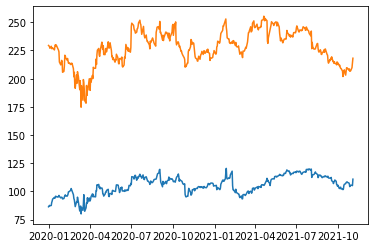

In [2]:
start = '2020-01-01'
end = date.today()
akam = yf.download('AKAM', start, end)
amgn = yf.download('AMGN', start, end)
plt.plot(akam['Adj Close'])
plt.plot(amgn['Adj Close'])
df1 = pd.DataFrame({'AKAM': akam['Adj Close'], 'AMGN': amgn['Adj Close']})
est = sm.OLS(df1.AKAM, df1.AMGN)
est = est.fit()
df1['hr'] = -est.params[0]
df1['spread'] = df1.AKAM + (df1.AMGN * df1.hr)
cadf = ts.adfuller(df1.spread)
print('Augmented Dickey-Fuller test statistic =',cadf[0])
print('Augmented Dickey-Fuller p-value =',cadf[1])
print('Augmented Dickey-Fuller 1%, 5% and 10% test statistics =',cadf[4])

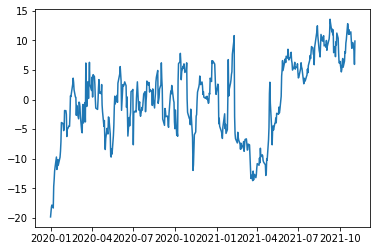

In [3]:
plt.plot(df1.spread)
plt.show()

In [4]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

Augmented Dickey Fuller test statistic = -4.077665786047155
Augmented Dickey Fuller p-value = 0.0010542094854691906
Augmented Dickey Fuller 1%, 5% and 10% test statistics = {'1%': -3.4444914328761977, '5%': -2.8677756786103683, '10%': -2.570091378194011}


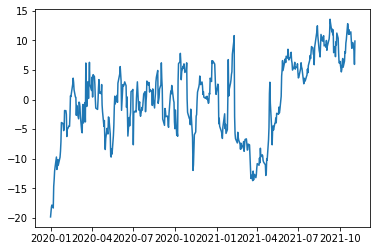

In [5]:
#df1 = pd.DataFrame({'AKAM': prices['AKAM']['Adj Close'], 'AMGN': prices['AMGN']['Adj Close']})
est = sm.OLS(df1.AKAM, df1.AMGN)
est = est.fit()
df1['hr'] = -est.params[0]
df1['spread'] = df1.AKAM + (df1.AMGN * df1.hr)
cadf = ts.adfuller(df1.spread)
print('Augmented Dickey Fuller test statistic =',cadf[0])
print('Augmented Dickey Fuller p-value =',cadf[1])
print('Augmented Dickey Fuller 1%, 5% and 10% test statistics =',cadf[4])
plt.plot(df1.spread)
plt.show()

In [6]:
hurst(df1.spread)

C:\Users\alane\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


nan

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

stocks = ['AKAM', 'AMGN']
start = '2020-4-30'
end = date.today()
fee = 0.001
window = 252
t_threshold = -2.5
data = pd.DataFrame()
returns = pd.DataFrame()
for stock in stocks:
    prices = yf.download(stock, start, end)
    data[stock] = prices['Adj Close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True) - 1, 0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


day 2021-04-29 00:00:00

long position on AMGN and short position on AKAM
gross daily return: 3.28%
gross daily return: 3.18%
cumulative net return so far: 3.18%

day 2021-04-30 00:00:00

long position on AMGN and short position on AKAM
gross daily return: 3.94%
gross daily return: 3.94%
cumulative net return so far: 7.25%

day 2021-05-03 00:00:00

long position on AKAM and short position on AKAM
gross daily return: -2.52%
gross daily return: -2.72%
cumulative net return so far: 4.33%

day 2021-05-04 00:00:00

long position on AKAM and short position on AKAM
gross daily return: 2.35%
gross daily return: 2.35%
cumulative net return so far: 6.79%

day 2021-05-05 00:00:00

long position on AKAM and short position on AKAM
gross daily return: 0.76%
gross daily return: 0.76%
cumulative net return so far: 7.6%

day 2021-05-06 00:00:00

long position on AKAM and short position on AKAM
gross daily return: -0.59%
gross daily return: -0.59%
cumulative net return so far: 6.97%

day 2021-05-07 00:0

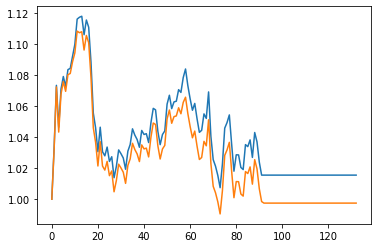

In [8]:
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
stock1 = stocks[0]
stock2 = stocks[1]

for t in range(window, len(data)):
    def unit_root(b):
        a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t])
        fair_value = a + b*data[stock1][t-window:t]
        diff = np.array(fair_value - data[stock2][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0]/res.bse[0]
    res1 = spop.minimize(unit_root, data[stock2][t]/data[stock1][t], method = 'Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])
    fair_value = a_opt + b_opt * data[stock1][t]
    if t == window: 
        old_signal = 0
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[stock2][t])
        gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]
    fees = fee*abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    
    print('day '+str(data.index[t]))
    print('')
    if signal == 0:
        print('no trading')
    elif signal == 1:
        print('long position on '+stock2+' and short position on '+stock1)
    else:
        print('long position on '+stock1+' and short position on '+stock1)
    print('gross daily return: '+str(round(gross_return*100, 2))+'%')
    print('gross daily return: '+str(round(net_return*100, 2))+'%')
    print('cumulative net return so far: '+str(round(np.prod(1+net_returns)*100 -100, 2))+'%')
    print('')
    old_signal = signal
plt.plot(np.append(1, np.cumprod(1+gross_returns)))
plt.plot(np.append(1, np.cumprod(1+net_returns)))

In [ ]:
start = '2020-04-30'
end = date.today()
akam = yf.download('AKAM', start, end)
amgn = yf.download('AMGN', start, end)
plt.plot(akam['Adj Close'])
plt.plot(amgn['Adj Close'])

In [ ]:
from numpy import polyfit
lags = range(2,100)
def hurst_ernie_chan(p):

    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

In [ ]:
df1